<a href="https://colab.research.google.com/github/29-sherin/21032279-Istanbul-stock-market/blob/main/Istanbul_stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT NECESSARY LIBRARIES**

In [1]:
import pandasas pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [4]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/ data_preprocessed_v1.xlsx'
istanbul_df = pd.read_excel(file_path, header=1)
istanbul_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


# **Summary Statistics**

In [5]:
# Print summary statistics of the dataset
print(istanbul_df.describe())

                                Date         ISE       ISE.1          SP  \
count                            536  536.000000  536.000000  536.000000   
mean   2010-01-26 03:37:36.716418048    0.001629    0.001552    0.000643   
min              2009-01-05 00:00:00   -0.062208   -0.084716   -0.054262   
25%              2009-07-14 18:00:00   -0.006669   -0.009753   -0.004675   
50%              2010-01-27 12:00:00    0.002189    0.002643    0.000876   
75%              2010-08-05 06:00:00    0.010584    0.013809    0.006706   
max              2011-02-22 00:00:00    0.068952    0.100621    0.068366   
std                              NaN    0.016264    0.021122    0.014093   

              DAX        FTSE      NIKKEI     BOVESPA          EU          EM  
count  536.000000  536.000000  536.000000  536.000000  536.000000  536.000000  
mean     0.000721    0.000510    0.000308    0.000935    0.000471    0.000936  
min     -0.052331   -0.054816   -0.050448   -0.053849   -0.048817   -0.0385

# **DATA PREPROCESSING**

In [6]:
# Data Cleaning and Preparation
istanbul_df = istanbul_df.rename(columns={'ISE.1': 'USD_BASED_ISE'})
istanbul_df['Date'] = pd.to_datetime(istanbul_df['Date'], format='%Y-%m-%d')

# Check for missing values and handle them
istanbul_df = istanbul_df.dropna()
istanbul_df.count()

Date             536
ISE              536
USD_BASED_ISE    536
SP               536
DAX              536
FTSE             536
NIKKEI           536
BOVESPA          536
EU               536
EM               536
dtype: int64

In [7]:
# Rename columns for convenience
istanbul_df.rename(columns={'ISE.1': 'USD_BASED_ISE'}, inplace=True)
istanbul_df.head()

# Convert 'Date' column to datetime
istanbul_df['Date'] = pd.to_datetime(istanbul_df['Date'], format='%Y-%m-%d')

# Split 'Date' into 'day', 'month', and 'year'
istanbul_df['day'] = istanbul_df['Date'].dt.day
istanbul_df['month'] = istanbul_df['Date'].dt.month
istanbul_df['year'] = istanbul_df['Date'].dt.year

# Drop 'Date' column
istanbul_df.drop(columns=['Date'], inplace=True)

# Create a copy of the dataframe
istanbul_df_copy = istanbul_df.copy()

istanbul_df_copy.head()

,ISE,USD_BASED_ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM,day,month,year
0,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524,5,1,2009
1,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773,6,1,2009
2,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015,7,1,2009
3,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424,8,1,2009
4,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802,9,1,2009


#**Exploratory Data Analysis (EDA)**

1.   Histograms of Predictor Variables



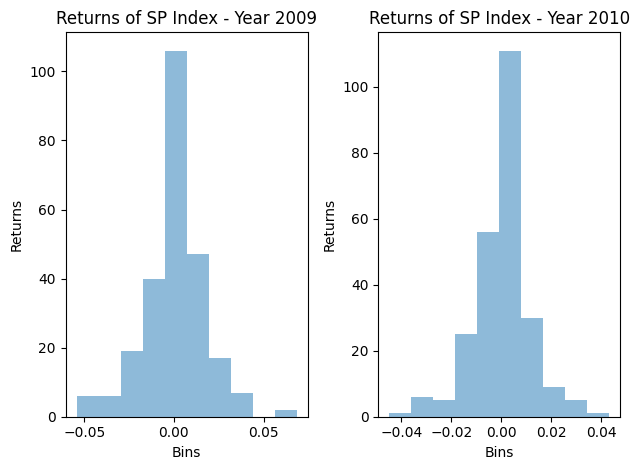

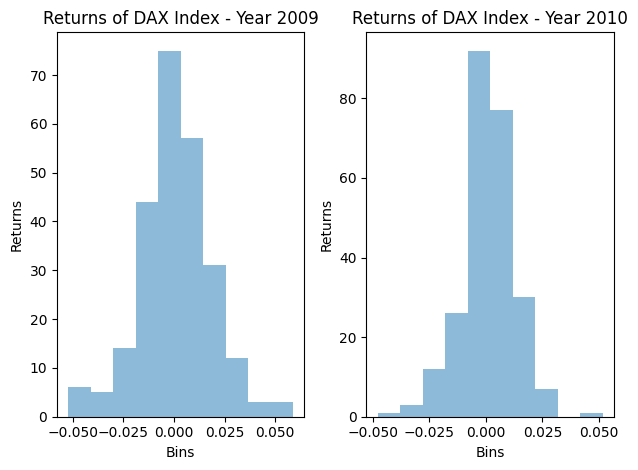

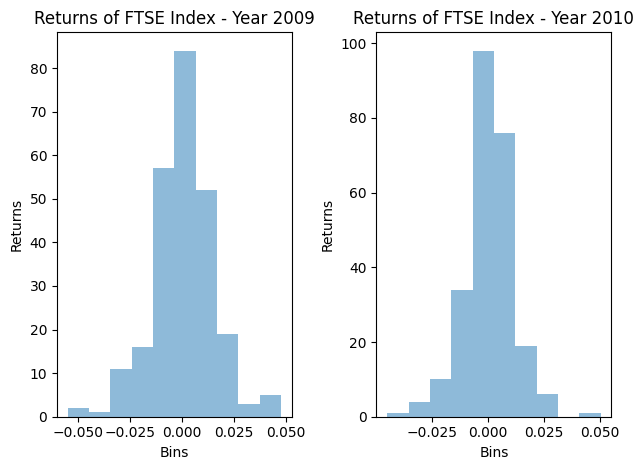

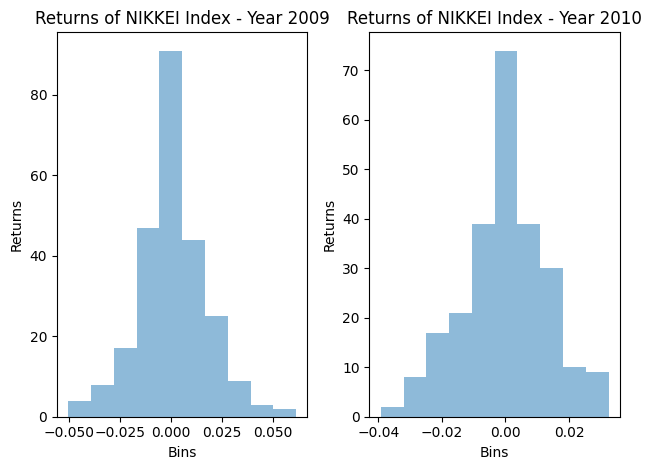

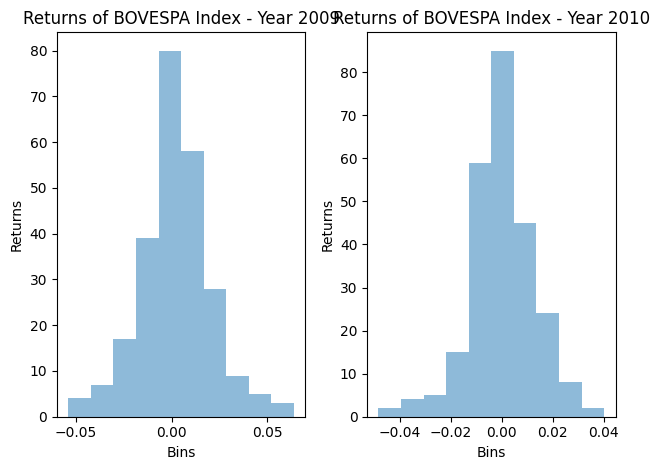

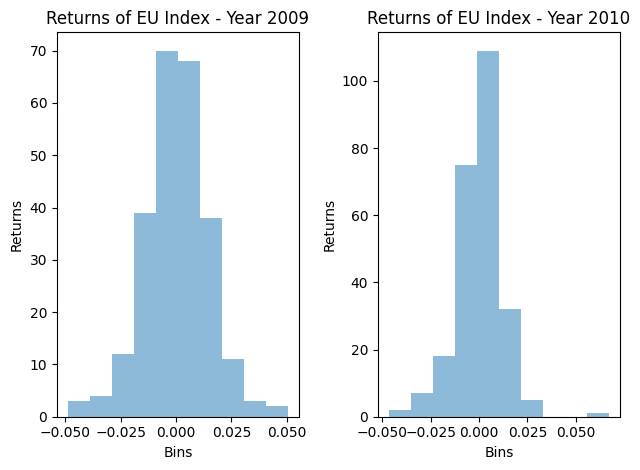

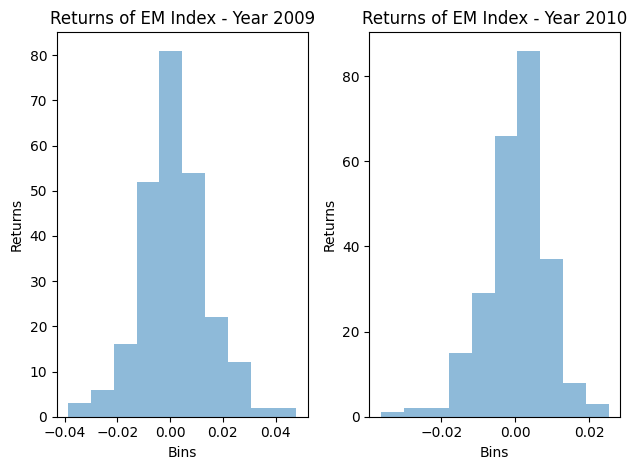

In [8]:
# List of predictor variables
predictors = ['SP', 'DAX', 'FTSE', 'NIKKEI', 'BOVESPA', 'EU', 'EM']

# Plot histograms for the years 2009 and 2010
for pred in predictors:
    plt.subplot(1, 2, 1)
    plt.hist(istanbul_df_copy[istanbul_df_copy.year == 2009][pred], alpha=0.5)
    plt.xlabel('Bins')
    plt.ylabel('Returns')
    plt.title(f'Returns of {pred} Index - Year 2009')

    plt.subplot(1, 2, 2)
    plt.hist(istanbul_df_copy[istanbul_df_copy.year == 2010][pred], alpha=0.5)
    plt.xlabel('Bins')
    plt.ylabel('Returns')
    plt.title(f'Returns of {pred} Index - Year 2010')

    plt.tight_layout()
    plt.show()


2.  Bar Plot of Average Returns

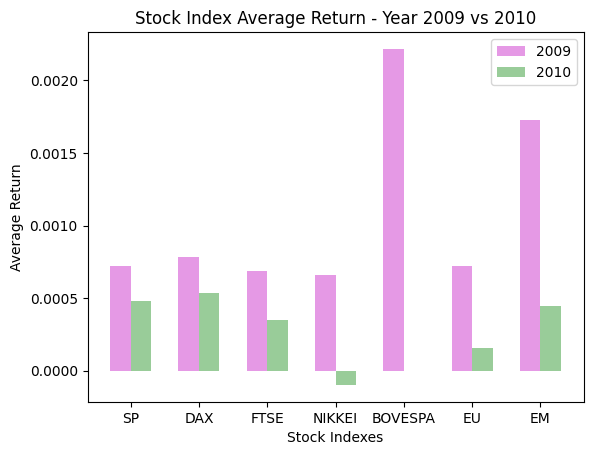

In [9]:
# Average returns for 2009
year_2009 = istanbul_df_copy[istanbul_df_copy.year == 2009]
avg_returns_2009 = [np.average(year_2009[pred]) for pred in predictors]

# Average returns for 2010
year_2010 = istanbul_df_copy[istanbul_df_copy.year == 2010]
avg_returns_2010 = [np.average(year_2010[pred]) for pred in predictors]

# Plot grouped bar plot
bar_width = 0.3
width_2009 = np.arange(len(avg_returns_2009))
width_2010 = width_2009 + bar_width

plt.bar(width_2009, avg_returns_2009, width=bar_width, color='m', alpha=0.4, label='2009')
plt.bar(width_2010, avg_returns_2010, width=bar_width, color='g', alpha=0.4, label='2010')

plt.xlabel('Stock Indexes')
plt.xticks(width_2009 + bar_width / 2, predictors)
plt.ylabel('Average Return')
plt.title('Stock Index Average Return - Year 2009 vs 2010')
plt.legend()
plt.show()

#**Split the data into train and test sets**

In [10]:
# Define predictors and response
predictors = ['SP', 'DAX', 'FTSE', 'NIKKEI', 'BOVESPA', 'EU', 'EM']
response = 'USD_BASED_ISE'

# Split the data into train and test sets
X = istanbul_df_copy[predictors]
y = istanbul_df_copy[response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#**Data Visualization**

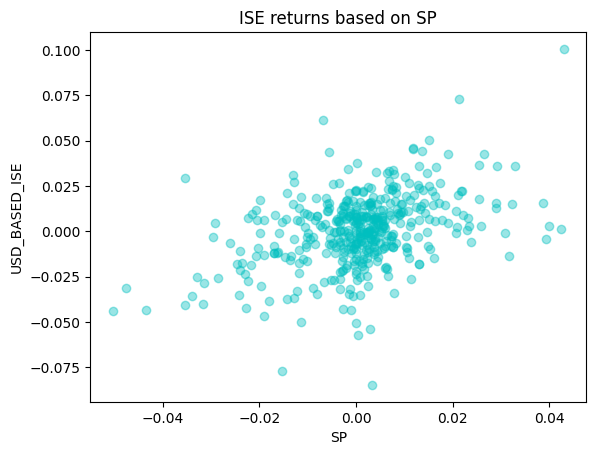

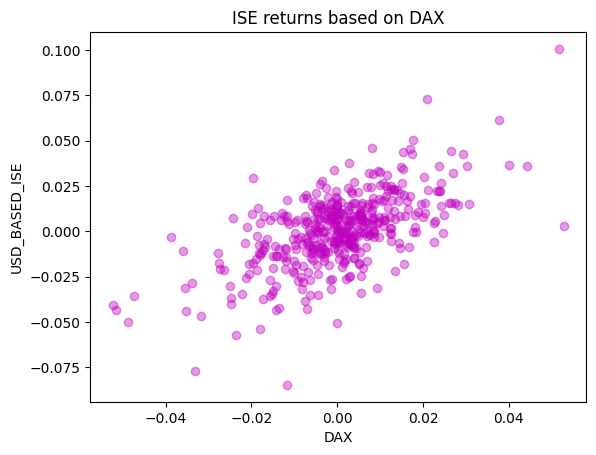

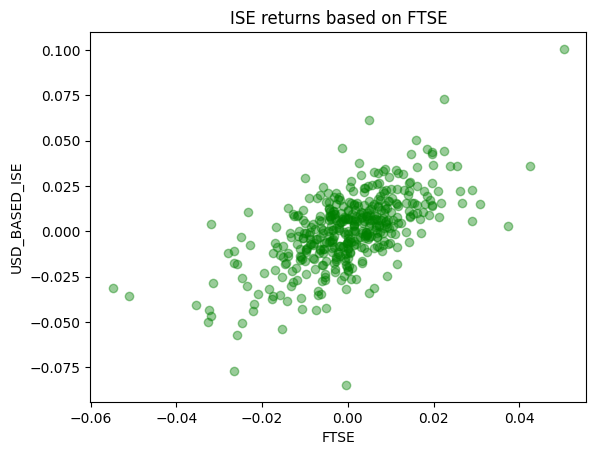

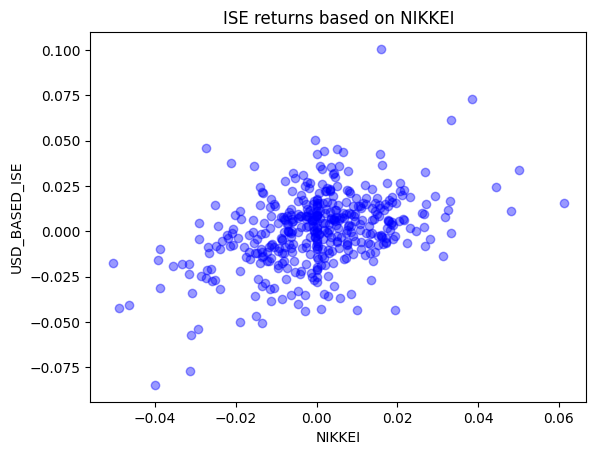

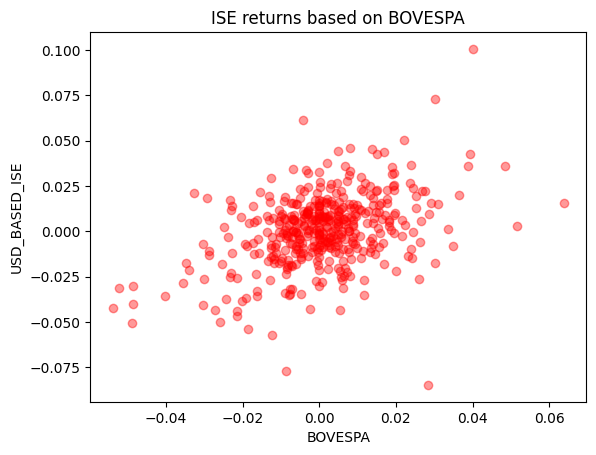

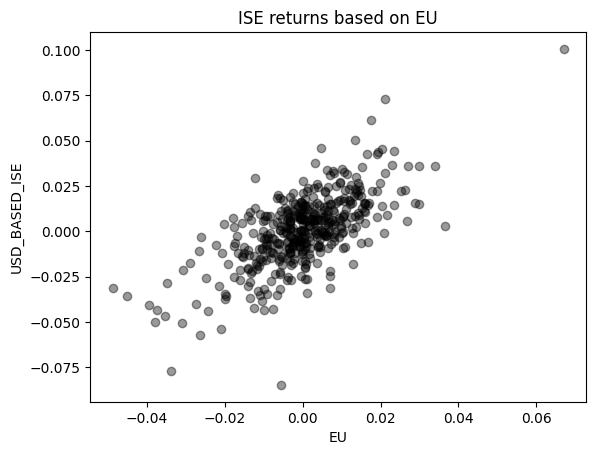

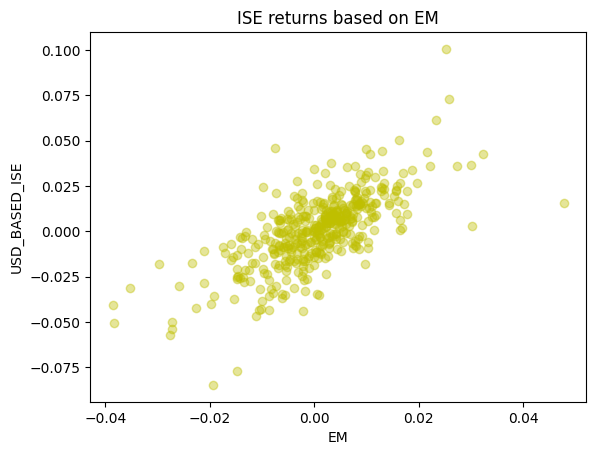

In [11]:
# Visualize relationship between predictors and response
predictors = list(X_train.columns)
colors = ['c', 'm', 'g', 'b', 'r', 'k', 'y']
response = 'USD_BASED_ISE'

for i, color in zip(predictors, colors):
    plt.scatter(X_train[i], y_train, c=color, alpha=0.4)
    plt.xlabel(i)
    plt.ylabel(response)
    plt.title(f'ISE returns based on {i}')
    plt.show()

#**Correlation Analysis**

               SP       DAX      FTSE    NIKKEI   BOVESPA        EU        EM
SP       1.000000  0.652379  0.616251  0.180477  0.731896  0.657009  0.500183
DAX      0.652379  1.000000  0.862255  0.284006  0.554599  0.937136  0.658444
FTSE     0.616251  0.862255  1.000000  0.301778  0.555731  0.944341  0.678129
NIKKEI   0.180477  0.284006  0.301778  1.000000  0.191834  0.316633  0.585041
BOVESPA  0.731896  0.554599  0.555731  0.191834  1.000000  0.584551  0.648230
EU       0.657009  0.937136  0.944341  0.316633  0.584551  1.000000  0.708545
EM       0.500183  0.658444  0.678129  0.585041  0.648230  0.708545  1.000000


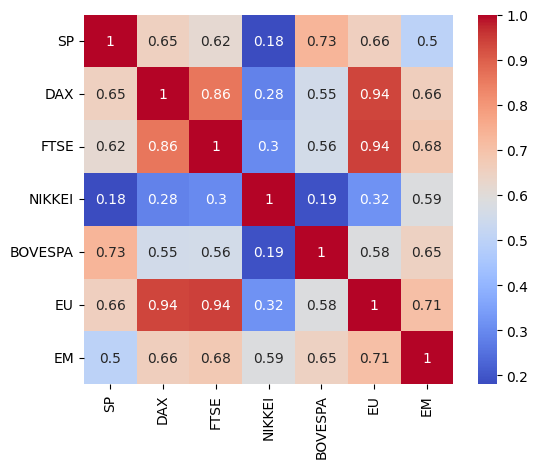

In [12]:
# Calculate correlation matrix
corr = X_train.corr()
print(corr)

# Plot heatmap
sns.heatmap(corr, cmap='coolwarm', annot=True, square=True)
plt.show()

#**Trained Model**

#1. Linear Regression

In [13]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)

# Evaluate Linear Regression
r2_lin_reg = r2_score(y_test, y_pred_lin_reg)
mse_lin_reg = mean_squared_error(y_test, y_pred_lin_reg)

print(f"Linear Regression R^2: {r2_lin_reg}")
print(f"Linear Regression MSE: {mse_lin_reg}")

Linear Regression R^2: 0.5827104620232106
Linear Regression MSE: 0.00024291904818879423


# 2. Random Forest

In [14]:
# Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf_reg = rf_reg.predict(X_test)

# Evaluate Random Forest
r2_rf_reg = r2_score(y_test, y_pred_rf_reg)
mse_rf_reg = mean_squared_error(y_test, y_pred_rf_reg)

print(f"Random Forest R^2: {r2_rf_reg}")
print(f"Random Forest MSE: {mse_rf_reg}")

Random Forest R^2: 0.5230664806944334
Random Forest MSE: 0.00027763992627460594


# 3. Decision Tree

In [15]:
# Decision Tree
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)
y_pred_dt_reg = dt_reg.predict(X_test)

# Evaluate Decision Tree
r2_dt_reg = r2_score(y_test, y_pred_dt_reg)
mse_dt_reg = mean_squared_error(y_test, y_pred_dt_reg)

print(f"Decision Tree R^2: {r2_dt_reg}")
print(f"Decision Tree MSE: {mse_dt_reg}")

Decision Tree R^2: 0.14009800943707562
Decision Tree MSE: 0.0005005794635925281


# 4. Long Short-Term Memory (LSTM)

In [16]:
# Scale the data for LSTM
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaled_X_train = scaler_X.fit_transform(X_train)
scaled_X_test = scaler_X.transform(X_test)

scaled_y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
scaled_y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input to be 3D [samples, timesteps, features]
X_train_lstm = scaled_X_train.reshape((scaled_X_train.shape[0], 1, scaled_X_train.shape[1]))
X_test_lstm = scaled_X_test.reshape((scaled_X_test.shape[0], 1, scaled_X_test.shape[1]))

# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(1, len(predictors))))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_lstm, scaled_y_train, epochs=20, batch_size=1, verbose=2)

# Predict with LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Inverse transform the predictions
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)

# Evaluate LSTM
r2_lstm = r2_score(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)

print(f"LSTM R^2: {r2_lstm}")
print(f"LSTM MSE: {mse_lstm}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


428/428 - 5s - 12ms/step - loss: 0.0167
Epoch 2/20
428/428 - 2s - 5ms/step - loss: 0.0067
Epoch 3/20
428/428 - 2s - 4ms/step - loss: 0.0063
Epoch 4/20
428/428 - 1s - 3ms/step - loss: 0.0063
Epoch 5/20
428/428 - 1s - 3ms/step - loss: 0.0058
Epoch 6/20
428/428 - 1s - 2ms/step - loss: 0.0060
Epoch 7/20
428/428 - 1s - 3ms/step - loss: 0.0059
Epoch 8/20
428/428 - 1s - 2ms/step - loss: 0.0058
Epoch 9/20
428/428 - 1s - 2ms/step - loss: 0.0061
Epoch 10/20
428/428 - 1s - 2ms/step - loss: 0.0060
Epoch 11/20
428/428 - 1s - 2ms/step - loss: 0.0061
Epoch 12/20
428/428 - 2s - 5ms/step - loss: 0.0060
Epoch 13/20
428/428 - 2s - 4ms/step - loss: 0.0060
Epoch 14/20
428/428 - 2s - 4ms/step - loss: 0.0057
Epoch 15/20
428/428 - 2s - 5ms/step - loss: 0.0058
Epoch 16/20
428/428 - 1s - 2ms/step - loss: 0.0057
Epoch 17/20
428/428 - 1s - 3ms/step - loss: 0.0061
Epoch 18/20
428/428 - 1s - 3ms/step - loss: 0.0056
Epoch 19/20
428/428 - 1s - 3ms/step - loss: 0.0059
Epoch 20/20
428/428 - 1s - 3ms/step - loss: 0.0057

#**Summary of Results**

In [17]:
from tabulate import tabulate

# Model performance metrics
metrics = [
    ['Linear Regression', r2_lin_reg, mse_lin_reg],
    ['Random Forest', r2_rf_reg, mse_rf_reg],
    ['Decision Tree', r2_dt_reg, mse_dt_reg],
    ['LSTM', r2_lstm, mse_lstm]
]

# Print in tabular form
print(tabulate(metrics, headers=['Model', 'R^2', 'MSE'], tablefmt='pretty'))

+-------------------+---------------------+------------------------+
|       Model       |         R^2         |          MSE           |
+-------------------+---------------------+------------------------+
| Linear Regression | 0.5827104620232106  | 0.00024291904818879423 |
|   Random Forest   | 0.5230664806944334  | 0.00027763992627460594 |
|   Decision Tree   | 0.14009800943707562 | 0.0005005794635925281  |
|       LSTM        |  0.512536480547178  | 0.0002837698130328534  |
+-------------------+---------------------+------------------------+


# **Compare the two best performing models (Linear Regression and LSTM)**

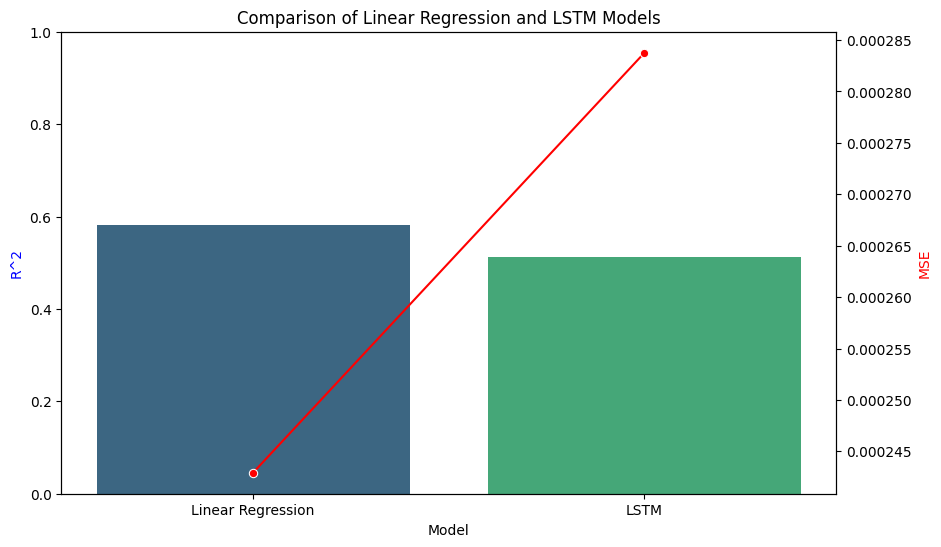

In [18]:
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'LSTM'],
    'R^2': [r2_lin_reg, r2_lstm],
    'MSE': [mse_lin_reg, mse_lstm]
})

# Plot the comparison
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for R^2
sns.barplot(x='Model', y='R^2', data=models_comparison, ax=ax1, palette='viridis', hue='Model', dodge=False)
ax1.set_ylabel('R^2', color='b')
ax1.set_ylim(0, 1)

# Twin axis for MSE
ax2 = ax1.twinx()
sns.lineplot(x='Model', y='MSE', data=models_comparison, ax=ax2, color='r', marker='o')
ax2.set_ylabel('MSE', color='r')

plt.title('Comparison of Linear Regression and LSTM Models')
plt.show()

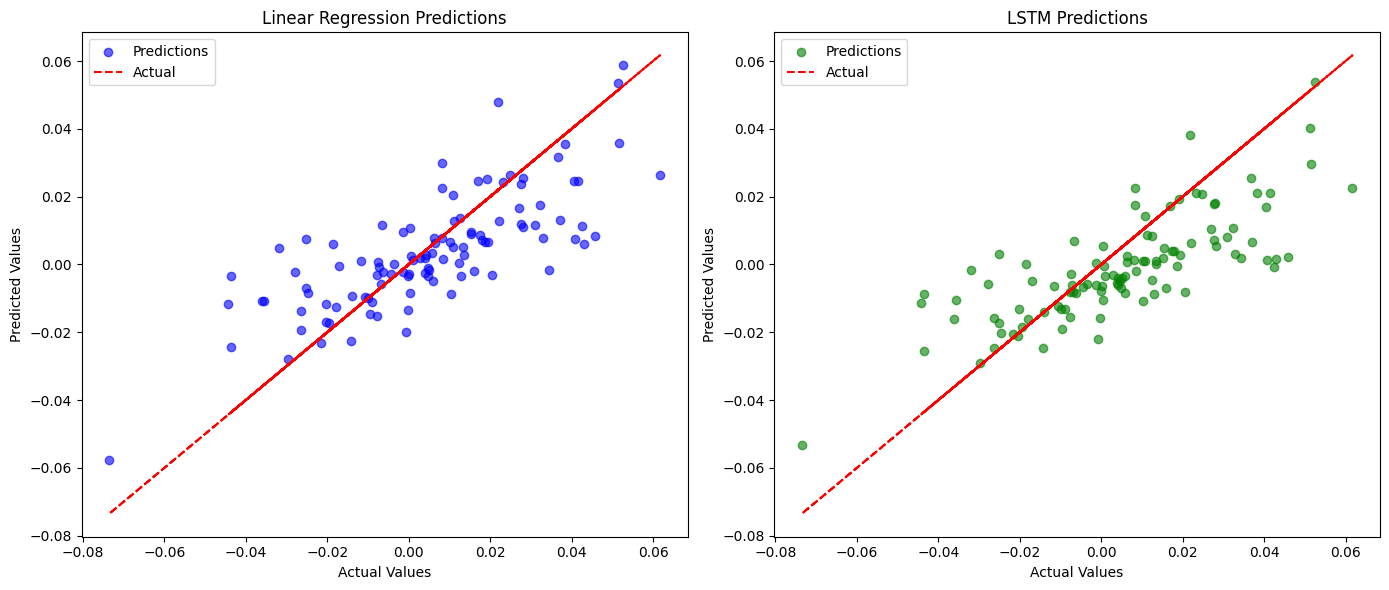

In [19]:
# Detailed visualization of predictions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Linear Regression predictions
axes[0].scatter(y_test, y_pred_lin_reg, color='blue', alpha=0.6, label='Predictions')
axes[0].plot(y_test, y_test, color='red', linestyle='--', label='Actual')
axes[0].set_title('Linear Regression Predictions')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].legend()

# LSTM predictions
axes[1].scatter(y_test, y_pred_lstm, color='green', alpha=0.6, label='Predictions')
axes[1].plot(y_test, y_test, color='red', linestyle='--', label='Actual')
axes[1].set_title('LSTM Predictions')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].legend()

plt.tight_layout()
plt.show()